In [1]:
import sklearn
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from eli5 import show_weights, show_prediction
from xgboost import plot_importance
import seaborn as sns
from sklearn.manifold import TSNE

#custom
from py.helper import DataProcessing
from py.ml_metrics import plot_confusion_matrix, multiclass_logloss, evaluate_model
from py.plotting import plot_tsne

#global
sns.set(rc={'figure.figsize':(15,15)})

/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
# set K-mer length here
kmer = 4

In [3]:
orf1 = DataProcessing('coronavirus_orf1ab.fasta', 'coronavirus_orf1ab_meta.csv')

In [4]:
#this will take a while
# kmers = orf1.get_amino_kmer_df(4)
amino_df = orf1.get_amino_df(kmer, 'csv')
print(amino_df.shape)
amino_df.drop_duplicates(subset='Accession', keep=False, inplace=True)
print(amino_df.shape)
amino_df.head()

(3046, 13)
(2384, 13)


,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,Collection_Date,GenBank_Title,seq_offset_0,seq_offset_1,seq_offset_2,seq_offset_3
1,YP_009555238,2019-02-21T00:00:00Z,Betacoronavirus 1,7095,USA,NaN,NaN,NaN,Orf1ab [Human coronavirus OC43],MSKINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQK...,SKINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQKL...,KINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQKLE...,INKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQKLET...
2,YP_002308478,2018-08-24T00:00:00Z,Bulbul coronavirus HKU11,6264,Hong Kong,Pycnonotus jocosus,NaN,2007-01,orf1ab polyprotein [Bulbul coronavirus HKU11-934],MVKNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNL...,VKNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNLV...,KNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNLVT...,NVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNLVTS...
3,YP_009513008,2018-08-24T00:00:00Z,Hedgehog coronavirus 1,7150,Germany,Erinaceus europaeus,feces,2012,orf1ab [Betacoronavirus Erinaceus/VMC/DEU/2012],MSSATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALS...,SSATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSP...,SATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSPW...,ATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALSPWF...
4,YP_009513020,2018-08-24T00:00:00Z,Coronavirus HKU15,6267,China: Hong Kong,Sus scrofa,NaN,2010,replicase polyprotein [Porcine coronavirus HKU15],MAKNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNL...,AKNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLY...,KNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLYA...,NKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLYAT...
5,YP_009389424,2017-07-14T00:00:00Z,Wencheng Sm shrew coronavirus,6324,China,Suncus murinus,NaN,2015,ORF1ab polyprotein [Wencheng Sm shrew coronavi...,MSVSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAY...,SVSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAYG...,VSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAYGL...,SKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAYGLQ...


Split the data

In [5]:
#split dataframe
mask = np.random.rand(len(amino_df)) < 0.8
train_df = amino_df[mask]
test_df = amino_df[~mask]
print(f'Size of the test df: {len(test_df)}. Size of the tain df: {len(train_df)}.')

Size of the test df: 435. Size of the tain df: 1949.


In [6]:
#split
xtrain = train_df['seq_offset_0'].values
xtest = test_df['seq_offset_0'].values

In [7]:
#vectorize
ctv = CountVectorizer(analyzer='char', ngram_range=(kmer, kmer), lowercase=False) # kmer: k-mer length

ctv.fit(list(xtrain)+list(xtest))
xtrain_ctv = ctv.transform(xtrain)
xtest_ctv = ctv.transform(xtest)

In [8]:
#K-means clustering
def run_kmeans(k):
    class_dict = dict(zip(range(k), [f'cluster_{i}' for i in range(k)]))
    kmeans = MiniBatchKMeans(n_clusters=k,verbose=0, batch_size=100)
    ytrain = kmeans.fit_predict(xtrain_ctv)
    ytest = kmeans.fit_predict(xtest_ctv)
    return ytrain, ytest, class_dict

Multiclass log loss: 7.797093312123026
dict_values(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])
Normalized confusion matrix
[[0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.8 0.2 0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


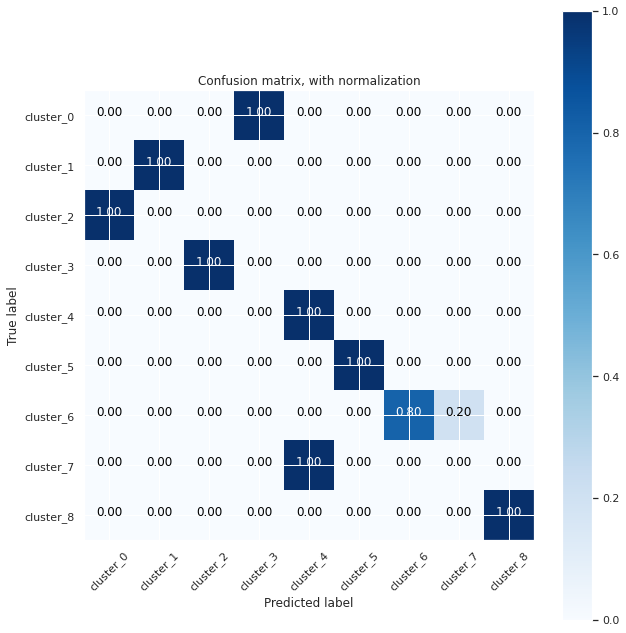

In [9]:
ytrain, ytest, class_dict = run_kmeans(9)
#fit logistic regression on CountVectorizer
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0, max_iter=4000)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xtest_ctv)
evaluate_model(predictions, ytest, class_dict)

In [12]:
from eli5 import show_weights
import eli5
# feature weights as df!
explanation = eli5.formatters.as_dataframe.explain_weights_df(clf, 
feature_names=ctv.get_feature_names())
# show_weights(clf, target_names=class_dict, vec=ctv)
show_weights(clf, vec=ctv, top=25, feature_filter=lambda x: x != '<BIAS>', target_names=class_dict)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(ytest, [i.argmax() for i in predictions], target_names=class_dict.values()))

              precision    recall  f1-score   support

   cluster_0       0.00      0.00      0.00       119
   cluster_1       1.00      1.00      1.00       101
   cluster_2       0.00      0.00      0.00        53
   cluster_3       0.00      0.00      0.00        45
   cluster_4       0.82      1.00      0.90        32
   cluster_5       1.00      1.00      1.00        20
   cluster_6       1.00      0.80      0.89        46
   cluster_7       0.00      0.00      0.00         7
   cluster_8       1.00      1.00      1.00        12

    accuracy                           0.46       435
   macro avg       0.54      0.53      0.53       435
weighted avg       0.47      0.46      0.47       435



In [13]:
explanation.head()


,target,feature,weight
0,0,GFVI,0.007690
1,0,KNVL,0.007365
2,0,SVFN,0.006718
3,0,LLVD,0.006635
4,0,VDGV,0.006375


In [11]:
plot_tsne(xtrain_ctv, ytrain, 45, train_df)

NameError: name 'train_df' is not defined

In [ ]:
predict_analyze_labelled(10, ctv, clf, xtest_ctv, xtest ,class_dict, highlight=True)

In [ ]:
def fit_and_predict_xgb(clf, xtrain_ctv, ytrain, xtest_ctv):
    # Fitting a simple xgboost on CountVectorizer
    clf = xgb.XGBClassifiaer(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                            subsample=0.8, nthread=10, learning_rate=0.1)
    clf.fit(xtrain_ctv, ytrain)
    return clf.predict_proba(xtest_ctv)

In [ ]:
def evaluate_model(predictions, ytest, class_dict):
    y_pred = []
    for i in predictions:
        y_pred.append(i.argmax())

    print('F1 Score: ',sklearn.metrics.f1_score(ytest, y_pred, average='weighted'))
    print('Accuracy:', sklearn.metrics.accuracy_score(ytest, y_pred))
    from sklearn.metrics import confusion_matrix
    class_names = class_dict.values()
    print(class_names)
    cnf_matrix = confusion_matrix(ytest, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(9, 9))
    plot_confusion_matrix(cnf_matrix, class_names, True,
                          title='Confusion matrix, with normalization')
    plt.show()

In [ ]:
for k in range(4, 20):
    # run k-means
    ytrain, ytest, class_dict = run_kmeans(k)
    print('Number of labels: {}'.format(max(ytrain)+1))
    class_dict = dict(zip(range(k), range(k)))
    class_dict

    # make predictions
    predictions = fit_and_predict_xgb(clf, xtrain_ctv, ytrain, xtest_ctv)

    # evaluate model
    evaluate_model(predictions, ytest, class_dict)

In [ ]:
import pandas as pd
k_clusters = list(range(4, 20))

F1_score = [0.002, 0.089, 0.0, 0.249, 0.0, 0.430, 0.089, 0.410, 0.000, 0.079, 0.232, 0.178, 0.192, 0.245, 0.268, 0.000]
c_m = sns.color_palette("bright", len(set(F1_score)))
f1_df = pd.DataFrame({'Number of clusters':k_clusters, 'F1 Score':F1_score})
sns.barplot(x='Number of clusters', y='F1 Score', palette=c_m, data=f1_df)

In [ ]:
# show_weights(clf, target_names=class_dict, vec=ctv)
# show_weights(clf, vec=ctv, top=100, feature_filter=lambda x: x != '<BIAS>')

In [ ]:
booster = clf.get_booster()
original_feature_names = booster.feature_names
booster.feature_names = ctv.get_feature_names()
print(booster.get_dump()[0])
# recover original feature names
booster.feature_names = original_feature_names


In [ ]:
# show_prediction(clf, doc=amino_df.values[100], vec=ctv)

In [ ]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime import lime_text
from sklearn.pipeline import make_pipeline

#classes
class_names = list(class_dict.keys())

#make pipeline
pipe = make_pipeline(ctv, clf)

#instantiate explainer
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
#Predict and analyze labelled data
def predict_analyze_labelled(idx ,vec ,model, pred_vec, pred_df_values, class_dict, highlight=False):
    '''
    idx - index of the row to analyze
    vec - instantiated vectorizer
    model - trained model
    pred_vec - vectorized prediction data
    pred_df_fvalues = the list of values used for vectorizing df[column].values
    class_names = list of calss names
    highlight - False=do not return highlighted text | True=return highlighted text
    '''
    #make pipeline
    pipe = make_pipeline(vec, model)

    #instantiate explainer
    explainer = LimeTextExplainer(class_names=class_dict.keys())
    
    print('Row ID: {}| Text : {}'.format(idx, pred_df_values[idx]))
    exp = explainer.explain_instance(pred_df_values[idx], pipe.predict_proba, num_features=4, labels=[0, 1, 2, ])
    pred_class = clf.predict(pred_vec[idx]).reshape(1,-1)[0,0]
    print('Predicted class =', class_dict[pred_class])
    print ('Explanation for class %s' % class_dict[pred_class])
    print ('\n'.join(map(str, exp.as_list(label=pred_class))))
    
    if highlight:
        exp.show_in_notebook(text=pred_df_values[idx], labels=(pred_class,))

In [ ]:
predict_analyze_labelled(10, ctv, clf, xtest_ctv, xtest ,class_names, highlight=True)

In [ ]:
# clf.get_booster().get_score(importance_type="gain")


In [ ]:
# fig, ax = plt.subplots(figsize=(12,18))
# xgb.plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
# plt.show()

In [ ]:
# feature importances
clf.get_booster().feature_names = ctv.get_feature_names()
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf.get_booster(), max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
def plot_scatter(color_by, x_tsne):
    # sns settings
    sns.set(rc={'figure.figsize':(15,15)})

    # colors
    palette = sns.color_palette("bright", len(set(color_by)))

    # plot
    sns.scatterplot(x_tsne[:,0], x_tsne[:,1], hue=color_by, legend='full', palette=palette)
    plt.title("t-SNE K-means clusters")
    # plt.savefig("plots/plot.png")
    plt.show()

In [ ]:
def plot_tsne(xtrain_ctv, ytrain, perplexity):
    tsne = TSNE(verbose=1, perplexity=perplexity)
    x_tsne = tsne.fit_transform(xtrain_ctv)
    plot_scatter(ytrain, x_tsne)

In [ ]:
plot_tsne(xtrain_ctv, ytrain, 5)

In [ ]:
plot_tsne(xtrain_ctv, ytrain, 4)

In [ ]:
plot_tsne(xtrain_ctv, ytrain, 2)

In [ ]:
plot_tsne(xtrain_ctv, ytrain, 10)

In [ ]:
plot_tsne(xtrain_ctv, ytrain, 15)

In [ ]:
plot_tsne(xtrain_ctv, ytrain, 25)

In [ ]:
plot_tsne(xtrain_ctv, ytrain, 50)

In [ ]:
plot_tsne(xtrain_ctv, ytrain, 100)

In [ ]:
plot_tsne(xtrain_ctv, ytrain, 200)

In [ ]:
train_df['Geo_Location'].value_counts().plot(kind='bar')

In [ ]:
sns.countplot(ytrain, palette = sns.color_palette("bright", len(set(ytrain))))

In [ ]:
print(ytrain)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(xtrain_ctv)
  labels = kmeans.labels_
  sil.append(silhouette_score(xtrain_ctv, labels, metric = 'euclidean'))

In [ ]:
sns.distplot(sil, )

In [ ]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(points.shape[0]):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

sse = calculate_WSS(xtrain_ctv, kmax)

In [ ]:
sns.distplot(sse)

In [ ]:
sns.countplot(sse)